## 0. Load Device

In [24]:
# Check GPU

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Load Dataset

- Basic Dataset (e.g. MNIST) is provided via PyTorch's datasets(e.g. `torchvision.datasets`)
- You can also load custom dataset

In [25]:
# Load Dataset
# Note: this is a workaround to bypass known issue:
# Failed to download (trying next): <urlopen error [Errno 110] Connection timed out>
import torchvision.datasets as datasets
import socket

socket.setdefaulttimeout(5)

data_root = './data'

train_set0 = datasets.MNIST(
    root = data_root,
    train = True,
    download = True
)

## 2. Preprocess

### 2.1. Transform

In [26]:
# Preprocess Dataset
import torchvision.transforms as transforms

transform = transforms.Compose([
    # this transforms PIL.Image data into FloatTensor
    # changes each pixel value into 0.0 ... 1.0
    transforms.ToTensor(),
    # this normalizes each tensors into -1 ... 1
    # normalized_output = (input - avg) / std deviation
    # input 0.0 ... 1.0 so output is -1 ... 1
    transforms.Normalize(0.5, 0.5),
    # flatten because l1 is FC Layer
    # this isn't CNN so we transform this way.
    transforms.Lambda(lambda x: x.view(-1))
])

### 2.2. Split to Train / Test set

In [27]:
# Load and preprocess train dataset from MNIST
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform
    )

In [28]:
# Load and preprocess test dataset from MNIST
test_set = datasets.MNIST(
    root = data_root, train = False,
    download = True, transform = transform
    )

### 2.3. Divide into batches

Mini-batch helps GD avoid local minima because it adds randomness when updating the gradient. 

Also, shuffle helps the model avoid learning noise from the order of dataset.

In [29]:
# Chunk train, test dataset into mini batch size.
from torch.utils.data import DataLoader

# Mini-batch size
batch_size = 500

train_loader = DataLoader(
    train_set, batch_size = batch_size,
    # shuffle only for train to avoid learning
    # noise from the order of dataset
    shuffle = True
    )

test_loader = DataLoader(
    test_set, batch_size = batch_size,
    # does not require shuffle, because we don't update
    # the model parameter while validating
    shuffle = False
    )

## 3. Define the Neural Network

In [30]:
# set the input, output, hidden sizes
import numpy as np
image, _ = train_set[0]
n_input = image.shape[0]
n_output = len(train_set0.classes)
n_hidden = 128

In [31]:
# define the NN model (FC Layer with ReLU)

import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [32]:
# initialize NN and send it to device(cuda)

net = Net(n_input, n_output, n_hidden).to(device)

In [33]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [34]:
for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[ 0.0112, -0.0340,  0.0200,  ..., -0.0225, -0.0140,  0.0038],
        [ 0.0092,  0.0286, -0.0146,  ...,  0.0270,  0.0089,  0.0334],
        [-0.0036, -0.0277, -0.0329,  ..., -0.0242, -0.0205, -0.0173],
        ...,
        [-0.0069, -0.0207, -0.0022,  ...,  0.0289,  0.0323,  0.0300],
        [ 0.0128,  0.0001, -0.0018,  ..., -0.0261,  0.0028,  0.0149],
        [-0.0261,  0.0283, -0.0279,  ..., -0.0132,  0.0222, -0.0210]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0142, -0.0242,  0.0190,  0.0135,  0.0187,  0.0251,  0.0313, -0.0109,
         0.0192, -0.0286, -0.0200, -0.0231, -0.0069,  0.0217, -0.0081, -0.0061,
        -0.0002,  0.0245,  0.0014,  0.0247, -0.0327, -0.0080, -0.0018,  0.0077,
         0.0227, -0.0250,  0.0297, -0.0062,  0.0200, -0.0140, -0.0180, -0.0323,
        -0.0057,  0.0343, -0.0187, -0.0058,  0.0077,  0.0220,  0.0151,  0.0352,
        -0.0246, -0.0203,  0.0218,  0.0351, -0.0220

## 4. Train and Validate

In [35]:
# set hyperparameters for training, validating

from torch import optim

history = np.zeros((0,5))
num_epochs = 100
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)

In [36]:
# train and validate
import numpy as np
from tqdm.notebook import tqdm

# 500 x (120 + 20) = 70,000
for epoch in range(num_epochs):
    train_correct, train_loss = 0,0
    val_correct, val_loss = 0,0
    n_train, n_test = 0,0
    # set the model to training mode
    net.train()
    # main difference between train and validation is whether
    # we are going to update the gradient or not
    # 60,000 / batch_size=500 = 120 times
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels) # 0 ~ 120

        # load data to device(CUDA GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # initialize gradient to zero for every step
        optimizer.zero_grad()

        # forward function defined in NN is activated.
        # implement l1 -> relu -> l2 to input
        outputs = net(inputs)
        # SGD on outputs and labels
        loss = criterion(outputs, labels)
        # backward propagation
        loss.backward()
        # update gradient efficiently
        optimizer.step()
        # only get the indice of the max value
        predicted = torch.max(outputs, 1)[1]
        train_loss += loss.item()
        train_correct += (predicted == labels).sum().item()

    # set the model to evaluation mode
    net.eval()
    # 10,000 / batch_size=500 = 20 times
    # torch.no_grad disables gradient calculation for validation
    with torch.no_grad():
        for inputs_test, labels_test in tqdm(test_loader):
            n_test += len(labels_test)

            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            outputs_test = net(inputs_test)
            loss_test = criterion(outputs_test, labels_test)

            predicted_test = torch.max(outputs_test, 1)[1]

            val_loss += loss_test.item()
            val_correct += (predicted_test == labels_test).sum().item()
    
    train_acc = train_correct / n_train
    val_acc = val_correct / n_test

    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test

    print(f"Epoch [{epoch+1}/{num_epochs}], train_loss: {train_loss: .5f}, \
            train_acc: {train_acc: .5f}, val_loss: {val_loss: .5f}, \
            val_acc: {val_acc: .5f}")
    
    item = np.array([epoch+1, train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/100], train_loss:  1.80129,             train_acc:  0.59217, val_loss:  1.29639,             val_acc:  0.76720


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/100], train_loss:  1.01447,             train_acc:  0.80180, val_loss:  0.78190,             val_acc:  0.84070


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/100], train_loss:  0.69606,             train_acc:  0.84348, val_loss:  0.59401,             val_acc:  0.86530


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/100], train_loss:  0.56600,             train_acc:  0.86125, val_loss:  0.50485,             val_acc:  0.87570


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/100], train_loss:  0.49790,             train_acc:  0.87092, val_loss:  0.45397,             val_acc:  0.88290


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/100], train_loss:  0.45623,             train_acc:  0.87845, val_loss:  0.42012,             val_acc:  0.88830


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/100], train_loss:  0.42779,             train_acc:  0.88307, val_loss:  0.39707,             val_acc:  0.89320


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/100], train_loss:  0.40693,             train_acc:  0.88710, val_loss:  0.38141,             val_acc:  0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/100], train_loss:  0.39126,             train_acc:  0.89077, val_loss:  0.36738,             val_acc:  0.89810


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/100], train_loss:  0.37884,             train_acc:  0.89338, val_loss:  0.35561,             val_acc:  0.90020


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/100], train_loss:  0.36830,             train_acc:  0.89607, val_loss:  0.34647,             val_acc:  0.90330


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/100], train_loss:  0.35956,             train_acc:  0.89823, val_loss:  0.33988,             val_acc:  0.90450


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/100], train_loss:  0.35193,             train_acc:  0.89937, val_loss:  0.33223,             val_acc:  0.90450


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/100], train_loss:  0.34521,             train_acc:  0.90127, val_loss:  0.32635,             val_acc:  0.90630


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/100], train_loss:  0.33929,             train_acc:  0.90268, val_loss:  0.32144,             val_acc:  0.90900


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/100], train_loss:  0.33408,             train_acc:  0.90458, val_loss:  0.31778,             val_acc:  0.90950


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/100], train_loss:  0.32930,             train_acc:  0.90572, val_loss:  0.31295,             val_acc:  0.91020


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/100], train_loss:  0.32494,             train_acc:  0.90633, val_loss:  0.30908,             val_acc:  0.91330


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/100], train_loss:  0.32085,             train_acc:  0.90823, val_loss:  0.30573,             val_acc:  0.91400


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/100], train_loss:  0.31704,             train_acc:  0.90900, val_loss:  0.30283,             val_acc:  0.91470


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/100], train_loss:  0.31332,             train_acc:  0.91030, val_loss:  0.29864,             val_acc:  0.91640


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/100], train_loss:  0.30987,             train_acc:  0.91158, val_loss:  0.29705,             val_acc:  0.91540


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/100], train_loss:  0.30667,             train_acc:  0.91212, val_loss:  0.29443,             val_acc:  0.91610


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/100], train_loss:  0.30353,             train_acc:  0.91322, val_loss:  0.29068,             val_acc:  0.91800


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/100], train_loss:  0.30042,             train_acc:  0.91370, val_loss:  0.28789,             val_acc:  0.91760


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/100], train_loss:  0.29748,             train_acc:  0.91483, val_loss:  0.28596,             val_acc:  0.91880


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/100], train_loss:  0.29488,             train_acc:  0.91593, val_loss:  0.28349,             val_acc:  0.91990


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/100], train_loss:  0.29218,             train_acc:  0.91673, val_loss:  0.28159,             val_acc:  0.91960


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/100], train_loss:  0.28939,             train_acc:  0.91722, val_loss:  0.27890,             val_acc:  0.92070


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/100], train_loss:  0.28691,             train_acc:  0.91823, val_loss:  0.27687,             val_acc:  0.92130


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/100], train_loss:  0.28434,             train_acc:  0.91893, val_loss:  0.27487,             val_acc:  0.92160


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/100], train_loss:  0.28175,             train_acc:  0.91978, val_loss:  0.27243,             val_acc:  0.92180


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/100], train_loss:  0.27930,             train_acc:  0.92048, val_loss:  0.26999,             val_acc:  0.92220


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/100], train_loss:  0.27687,             train_acc:  0.92095, val_loss:  0.26870,             val_acc:  0.92330


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/100], train_loss:  0.27454,             train_acc:  0.92210, val_loss:  0.26559,             val_acc:  0.92340


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/100], train_loss:  0.27210,             train_acc:  0.92232, val_loss:  0.26418,             val_acc:  0.92410


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/100], train_loss:  0.26986,             train_acc:  0.92332, val_loss:  0.26174,             val_acc:  0.92440


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/100], train_loss:  0.26749,             train_acc:  0.92387, val_loss:  0.25998,             val_acc:  0.92590


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/100], train_loss:  0.26521,             train_acc:  0.92458, val_loss:  0.25852,             val_acc:  0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/100], train_loss:  0.26311,             train_acc:  0.92483, val_loss:  0.25605,             val_acc:  0.92650


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/100], train_loss:  0.26084,             train_acc:  0.92610, val_loss:  0.25486,             val_acc:  0.92710


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/100], train_loss:  0.25870,             train_acc:  0.92637, val_loss:  0.25215,             val_acc:  0.92700


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/100], train_loss:  0.25652,             train_acc:  0.92700, val_loss:  0.25110,             val_acc:  0.92900


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/100], train_loss:  0.25439,             train_acc:  0.92782, val_loss:  0.24879,             val_acc:  0.92900


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/100], train_loss:  0.25223,             train_acc:  0.92818, val_loss:  0.24750,             val_acc:  0.92870


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/100], train_loss:  0.25021,             train_acc:  0.92877, val_loss:  0.24547,             val_acc:  0.92960


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/100], train_loss:  0.24816,             train_acc:  0.92985, val_loss:  0.24343,             val_acc:  0.93180


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/100], train_loss:  0.24610,             train_acc:  0.93057, val_loss:  0.24188,             val_acc:  0.93210


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/100], train_loss:  0.24402,             train_acc:  0.93118, val_loss:  0.24047,             val_acc:  0.93110


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/100], train_loss:  0.24200,             train_acc:  0.93175, val_loss:  0.23783,             val_acc:  0.93300


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [51/100], train_loss:  0.24008,             train_acc:  0.93275, val_loss:  0.23674,             val_acc:  0.93270


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [52/100], train_loss:  0.23796,             train_acc:  0.93290, val_loss:  0.23471,             val_acc:  0.93410


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [53/100], train_loss:  0.23614,             train_acc:  0.93385, val_loss:  0.23289,             val_acc:  0.93390


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [54/100], train_loss:  0.23421,             train_acc:  0.93405, val_loss:  0.23143,             val_acc:  0.93380


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [55/100], train_loss:  0.23235,             train_acc:  0.93478, val_loss:  0.23020,             val_acc:  0.93420


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [56/100], train_loss:  0.23034,             train_acc:  0.93520, val_loss:  0.22822,             val_acc:  0.93310


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [57/100], train_loss:  0.22868,             train_acc:  0.93595, val_loss:  0.22656,             val_acc:  0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [58/100], train_loss:  0.22674,             train_acc:  0.93642, val_loss:  0.22515,             val_acc:  0.93590


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [59/100], train_loss:  0.22506,             train_acc:  0.93690, val_loss:  0.22325,             val_acc:  0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [60/100], train_loss:  0.22332,             train_acc:  0.93778, val_loss:  0.22138,             val_acc:  0.93650


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [61/100], train_loss:  0.22147,             train_acc:  0.93818, val_loss:  0.22042,             val_acc:  0.93720


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [62/100], train_loss:  0.21955,             train_acc:  0.93867, val_loss:  0.21877,             val_acc:  0.93770


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [63/100], train_loss:  0.21792,             train_acc:  0.93933, val_loss:  0.21825,             val_acc:  0.93800


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [64/100], train_loss:  0.21616,             train_acc:  0.94005, val_loss:  0.21566,             val_acc:  0.93900


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [65/100], train_loss:  0.21456,             train_acc:  0.94028, val_loss:  0.21423,             val_acc:  0.93820


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [66/100], train_loss:  0.21272,             train_acc:  0.94052, val_loss:  0.21267,             val_acc:  0.93830


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [67/100], train_loss:  0.21109,             train_acc:  0.94133, val_loss:  0.21090,             val_acc:  0.93920


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [68/100], train_loss:  0.20936,             train_acc:  0.94167, val_loss:  0.20926,             val_acc:  0.93990


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [69/100], train_loss:  0.20785,             train_acc:  0.94178, val_loss:  0.20854,             val_acc:  0.94060


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [70/100], train_loss:  0.20617,             train_acc:  0.94240, val_loss:  0.20751,             val_acc:  0.94090


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [71/100], train_loss:  0.20472,             train_acc:  0.94330, val_loss:  0.20507,             val_acc:  0.94080


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [72/100], train_loss:  0.20311,             train_acc:  0.94305, val_loss:  0.20362,             val_acc:  0.94150


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [73/100], train_loss:  0.20159,             train_acc:  0.94355, val_loss:  0.20250,             val_acc:  0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [74/100], train_loss:  0.20014,             train_acc:  0.94390, val_loss:  0.20156,             val_acc:  0.94200


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [75/100], train_loss:  0.19856,             train_acc:  0.94428, val_loss:  0.19935,             val_acc:  0.94250


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [76/100], train_loss:  0.19715,             train_acc:  0.94470, val_loss:  0.19819,             val_acc:  0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [77/100], train_loss:  0.19560,             train_acc:  0.94515, val_loss:  0.19700,             val_acc:  0.94370


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [78/100], train_loss:  0.19419,             train_acc:  0.94548, val_loss:  0.19595,             val_acc:  0.94330


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [79/100], train_loss:  0.19277,             train_acc:  0.94577, val_loss:  0.19469,             val_acc:  0.94470


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [80/100], train_loss:  0.19132,             train_acc:  0.94635, val_loss:  0.19274,             val_acc:  0.94470


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [81/100], train_loss:  0.18988,             train_acc:  0.94678, val_loss:  0.19171,             val_acc:  0.94490


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [82/100], train_loss:  0.18853,             train_acc:  0.94732, val_loss:  0.19082,             val_acc:  0.94460


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [83/100], train_loss:  0.18722,             train_acc:  0.94755, val_loss:  0.18940,             val_acc:  0.94550


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [84/100], train_loss:  0.18586,             train_acc:  0.94798, val_loss:  0.18852,             val_acc:  0.94560


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [85/100], train_loss:  0.18451,             train_acc:  0.94850, val_loss:  0.18635,             val_acc:  0.94670


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [86/100], train_loss:  0.18333,             train_acc:  0.94877, val_loss:  0.18558,             val_acc:  0.94650


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [87/100], train_loss:  0.18187,             train_acc:  0.94928, val_loss:  0.18455,             val_acc:  0.94660


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [88/100], train_loss:  0.18065,             train_acc:  0.94953, val_loss:  0.18346,             val_acc:  0.94660


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [89/100], train_loss:  0.17949,             train_acc:  0.95003, val_loss:  0.18218,             val_acc:  0.94730


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [90/100], train_loss:  0.17826,             train_acc:  0.94997, val_loss:  0.18095,             val_acc:  0.94760


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [91/100], train_loss:  0.17690,             train_acc:  0.95073, val_loss:  0.18009,             val_acc:  0.94720


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [92/100], train_loss:  0.17567,             train_acc:  0.95077, val_loss:  0.17864,             val_acc:  0.94820


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [93/100], train_loss:  0.17445,             train_acc:  0.95160, val_loss:  0.17810,             val_acc:  0.94850


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [94/100], train_loss:  0.17337,             train_acc:  0.95152, val_loss:  0.17675,             val_acc:  0.94850


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [95/100], train_loss:  0.17212,             train_acc:  0.95207, val_loss:  0.17572,             val_acc:  0.94940


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [96/100], train_loss:  0.17102,             train_acc:  0.95203, val_loss:  0.17470,             val_acc:  0.94950


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [97/100], train_loss:  0.16991,             train_acc:  0.95277, val_loss:  0.17371,             val_acc:  0.94980


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [98/100], train_loss:  0.16875,             train_acc:  0.95273, val_loss:  0.17305,             val_acc:  0.95020


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [99/100], train_loss:  0.16767,             train_acc:  0.95310, val_loss:  0.17203,             val_acc:  0.95080


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [100/100], train_loss:  0.16651,             train_acc:  0.95352, val_loss:  0.17112,             val_acc:  0.95110


## 5. Visualize Result

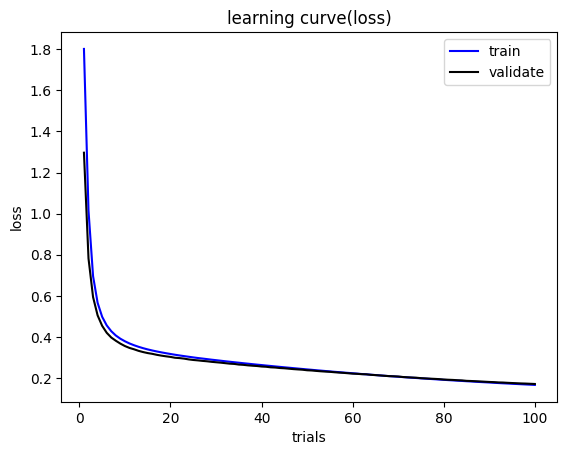

In [37]:
import matplotlib.pyplot as plt

plt.plot(history[:,0], history[:,1], 'b', label='train')
plt.plot(history[:,0], history[:,3], 'k', label='validate')
plt.xlabel('trials')
plt.ylabel('loss')
plt.title('learning curve(loss)')
plt.legend()
plt.show()

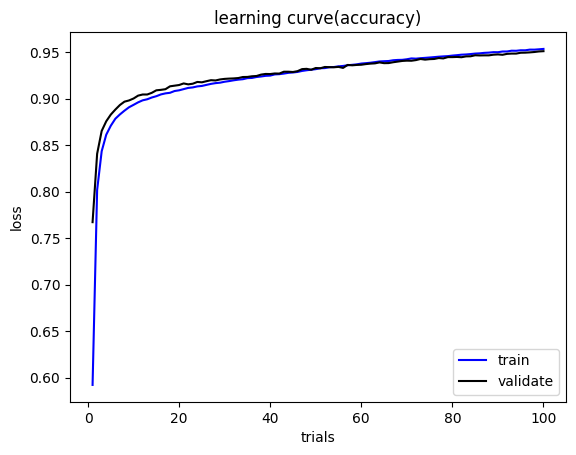

In [38]:
plt.plot(history[:,0], history[:,2], 'b', label='train')
plt.plot(history[:,0], history[:,4], 'k', label='validate')
plt.xlabel('trials')
plt.ylabel('loss')
plt.title('learning curve(accuracy)')
plt.legend()
plt.show()